In [288]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as pt
import time
from sklearn.tree._tree import TREE_LEAF

start_time = time.time()



data = pd.read_csv('UCI_Credit_Card.csv')


x = data.loc[:, data.columns != 'default.payment.next.month']
y = data['default.payment.next.month']
# print(y.head())


from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=1/3)



print ('training...')
clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, Y_train)



def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are shildren, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)
        
print(sum(clf.tree_.children_left < 0))

prune_index(clf.tree_, 0, 6)        
print(sum(clf.tree_.children_left < 0))

print ('training complete...')
print(clf.max_depth,clf.min_samples_split, clf.min_samples_leaf)
scores = cross_val_score(clf, X_train, Y_train)
print ('Accuracy {0}'.format(np.mean(scores)))
print(clf.score(X_test,Y_test))


training...
32
35
training complete...
5 2 1
Accuracy 0.816699681365857
0.8224


In [289]:
# Calculating F1 score
from sklearn.metrics import accuracy_score

predicted = clf.predict(X_test)
# print(predicted)
cc = accuracy_score(Y_test, predicted)
# print(cc)

print("--- %s seconds ---" % (time.time() - start_time))

from sklearn.metrics import f1_score
print(f1_score(Y_test, predicted, average='macro'))
print(f1_score(Y_test, predicted, average='micro'))
print(f1_score(Y_test, predicted, average='weighted'))

[0 0 0 ..., 0 0 0]
0.8224
--- 0.5005490779876709 seconds ---
0.690653363089
0.8224
0.802575421783


Confusion matrix, without normalization
Normalized confusion matrix


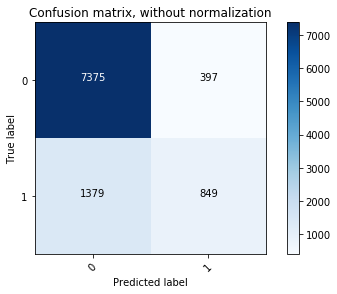

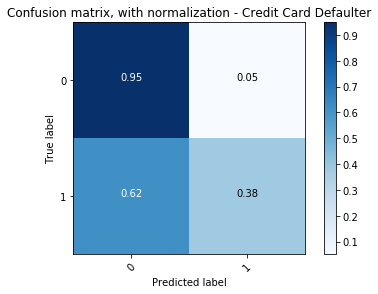

In [290]:
# Plotting confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    pt.imshow(cm, interpolation='nearest', cmap=cmap)
    pt.title(title)
    pt.colorbar()
    tick_marks = np.arange(len(classes))
    pt.xticks(tick_marks, classes, rotation=45)
    pt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pt.tight_layout()
    pt.ylabel('True label')
    pt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(Y_test, predicted)
pt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')
pt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],normalize=True,
                      title='Confusion matrix, with normalization - Credit Card Defaulter')
pt.show()

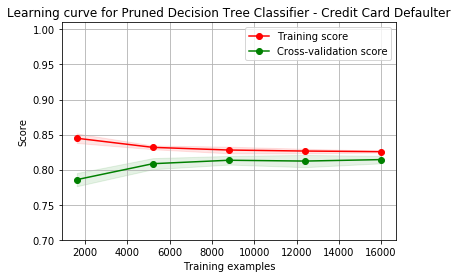

In [291]:
# Generate learning curve plot

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    pt.figure()
    pt.title(title)
    if ylim is not None:
        pt.ylim(*ylim)
    pt.xlabel("Training examples")
    pt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    pt.grid()

    pt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    pt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    pt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    pt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    pt.legend(loc="best")
    return pt
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)


plot_learning_curve(clf, "Learning curve for Pruned Decision Tree Classifier - Credit Card Defaulter", X_train, Y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

pt.show()